## <p style="text-align:center"> Сравнение данных за 2000, 2010, 2020 и составление рейтинга самых быстрорастущих регионов США (и быстроубывающих)  <br><br>  

## 1. Импорт необходимых библиотек

In [59]:
# Импорт необходимых библиотек
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import geodatasets
import time  

# Настройки для отображения графиков
sns.set(style="whitegrid")

## 2. Функция для загрузки и объединения данных за год

In [60]:
def load_and_combine_year_data(year_folder):
    """
    Загружает и объединяет все .asc файлы в указанной папке года.

    Parameters:
    year_folder (str): Путь к папке с файлами .asc для конкретного года.

    Returns:
    list: Список путей к .asc файлам.
    """
    # Получаем список всех .asc файлов в папке года
    files = glob.glob(os.path.join(year_folder, "*.asc"))

    # Проверяем, есть ли файлы
    if not files:
        raise ValueError(f"В папке {year_folder} не найдено файлов с расширением .asc")

    print(f"Найдено {len(files)} файлов для года {os.path.basename(year_folder)}")
    return files


## 2. Функция для вычисления статистики плотности населения

In [61]:
def calculate_zonal_statistics(shapefile, asc_file):
    """
    Вычисляет среднюю плотность населения для каждого региона.

    Parameters:
    shapefile (GeoDataFrame): Геоданные регионов.
    asc_file (str): Путь к .asc файлу с плотностью населения.

    Returns:
    GeoDataFrame: GeoDataFrame с добавленной колонкой 'population_density'.
    """
    stats = zonal_stats(shapefile, asc_file, stats="mean", nodata=-9999)
    shapefile = shapefile.copy()
    shapefile['population_density'] = [s['mean'] if s['mean'] is not None else 0 for s in stats]
    return shapefile

## 3. Функция для загрузки данных по плотности населения для всех годов

In [62]:
def load_all_zonal_stats(shapefile, data_folders):
    """
    Вычисляет плотность населения для всех годов, объединяя данные из нескольких файлов в один массив.

    Parameters:
    shapefile (GeoDataFrame): Геоданные регионов.
    data_folders (dict): Словарь с годами и путями к папкам данных.

    Returns:
    pd.DataFrame: DataFrame с плотностью населения для каждого региона и года.
    """
    shapefile = shapefile.rename(columns={'name': 'ADMIN'})
    results = shapefile[['ADMIN', 'iso_3166_2']].copy()
    results = results.rename(columns={'ADMIN': 'region_name', 'iso_3166_2': 'region_id'})
    
    for year, folder in data_folders.items():
        print(f"\nОбработка данных за {year} год")
        asc_files = load_and_combine_year_data(folder)
        
        # Создаем пустой массив для объединения данных
        combined_density = np.zeros_like(shapefile.geometry)  # или подходящая структура
        
        for asc_file in asc_files:
            print(f"Начинаем обработку файла {asc_file}")
            start_time = time.time()  # Начинаем отсчет времени
            
            # Выполняем обработку текущего файла
            year_stats = calculate_zonal_statistics(shapefile, asc_file)
            combined_density = np.maximum(combined_density, year_stats['population_density'])
            
            end_time = time.time()  # Завершаем отсчет времени
            print(f"Файл {asc_file} обработан за {end_time - start_time:.2f} секунд")
        
        results[year] = combined_density
        
    return results

## 4. Функция для вычисления изменения плотности населения

In [63]:
def calculate_population_change(df, current_year, previous_year):
    """
    Вычисляет изменение плотности населения между двумя годами.

    Parameters:
    df (pd.DataFrame): DataFrame с плотностью населения.
    current_year (str): Текущий год.
    previous_year (str): Предыдущий год.

    Returns:
    pd.Series: Изменение плотности населения.
    """
    change = df[current_year] - df[previous_year]
    return change

## 5. Функция для идентификации топ-10 регионов с ростом и спадом населения

In [64]:
def identify_top_regions(df, column, top_n=10):
    """
    Идентифицирует топ-N регионов с наибольшим ростом и спадом населения.

    Parameters:
    df (pd.DataFrame): DataFrame с данными о росте населения.
    column (str): Столбец для анализа.
    top_n (int): Количество топ регионов для отображения.

    Returns:
    tuple: Топ-N регионов с ростом и спадом.
    """
    top_growth = df.nlargest(top_n, column)
    top_decline = df.nsmallest(top_n, column)
    return top_growth, top_decline

## 6. Функция для визуализации результатов на карте

In [65]:
# Функция визуализации результатов
def visualize_top_regions(top_growth, top_decline, world, regions_gdf):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Отображение карты мира
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Координаты для регионов с ростом и спадом
    top_growth_centroids = regions_gdf.loc[top_growth.index, 'centroid']
    top_decline_centroids = regions_gdf.loc[top_decline.index, 'centroid']
    
    # Точки для регионов с ростом и спадом
    plt.scatter(top_growth_centroids.x, top_growth_centroids.y, color='green', s=100, label='Рост')
    plt.scatter(top_decline_centroids.x, top_decline_centroids.y, color='red', s=100, label='Спад')
    
    plt.legend()
    plt.title('Топ 10 регионов США с наибольшим ростом и спадом плотности населения (2000-2020)')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    
    # Устанавливаем фиксированные границы для отображения всей карты мира
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    
    plt.show()

## 7. Основной код выполнения программы

In [2]:
# Пути к данным за разные годы
data_folders = {
    '2000': "data/2000/",
    '2010': "data/2010/",
    '2020': "data/2020/"
}

In [67]:
# Загрузка shapefile с регионами (например, Admin 1 - States, Provinces)
regions_shapefile_path = "data/regions_shapefile/ne_110m_admin_1_states_provinces.shp"
regions_gdf = gpd.read_file(regions_shapefile_path)  

In [68]:
# Проверка наличия необходимых столбцов
required_columns = ['name', 'iso_3166_2', 'geometry']
if not all(col in regions_gdf.columns for col in required_columns):
    print(f"Shapefile должен содержать следующие столбцы: {required_columns}")
print("Найденные столбцы:", regions_gdf.columns)

Найденные столбцы: Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt',
       ...
       'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'FCLASS_TLC', 'geometry'],
      dtype='object', length=122)


In [18]:
# Загрузка всех данных плотности населения
population_df = load_all_zonal_stats(regions_gdf, data_folders)


Обработка данных за 2000 год
Найдено 8 файлов для года 
Начинаем обработку файла data/2000\gpw_v4_population_density_rev11_2000_30_sec_1.asc
Файл data/2000\gpw_v4_population_density_rev11_2000_30_sec_1.asc обработан за 473.22 секунд
Начинаем обработку файла data/2000\gpw_v4_population_density_rev11_2000_30_sec_2.asc
Файл data/2000\gpw_v4_population_density_rev11_2000_30_sec_2.asc обработан за 469.79 секунд
Начинаем обработку файла data/2000\gpw_v4_population_density_rev11_2000_30_sec_3.asc
Файл data/2000\gpw_v4_population_density_rev11_2000_30_sec_3.asc обработан за 1.10 секунд
Начинаем обработку файла data/2000\gpw_v4_population_density_rev11_2000_30_sec_4.asc
Файл data/2000\gpw_v4_population_density_rev11_2000_30_sec_4.asc обработан за 0.99 секунд
Начинаем обработку файла data/2000\gpw_v4_population_density_rev11_2000_30_sec_5.asc
Файл data/2000\gpw_v4_population_density_rev11_2000_30_sec_5.asc обработан за 0.81 секунд
Начинаем обработку файла data/2000\gpw_v4_population_density_rev

In [21]:
# Преобразование столбцов изменений в числовой формат
population_df['Change_2000_2010'] = pd.to_numeric(population_df['Change_2000_2010'], errors='coerce').fillna(0)
population_df['Change_2010_2020'] = pd.to_numeric(population_df['Change_2010_2020'], errors='coerce').fillna(0)
population_df['Change_2000_2020'] = pd.to_numeric(population_df['Change_2000_2020'], errors='coerce').fillna(0)

In [22]:
# Идентификация топ-10 регионов с ростом и спадом за 2000-2020 годы
top_growth, top_decline = identify_top_regions(population_df, 'Change_2000_2020', top_n=10)

    # Вывод результатов
print("Топ 10 регионов с наибольшим ростом населения (2000-2020):")
print(top_growth[['region_name', 'Change_2000_2020']])

print("\nТоп 10 регионов с наибольшим снижением населения (2000-2020):")
print(top_decline[['region_name', 'Change_2000_2020']])

Топ 10 регионов с наибольшим ростом населения (2000-2020):
             region_name  Change_2000_2020
43  District of Columbia        369.855484
42              Delaware         48.126672
45            New Jersey         46.704781
29               Florida         45.790858
44              Maryland         40.564813
23           Connecticut         27.727369
36        North Carolina         27.011013
30               Georgia         23.852365
39              Virginia         21.362984
3                 Hawaii         20.565114

Топ 10 регионов с наибольшим снижением населения (2000-2020):
     region_name  Change_2000_2020
14      Arkansas         -8.597230
21     Louisiana         -5.286990
49      Michigan         -0.195718
50        Alaska          0.075376
2   North Dakota          0.436916
1        Montana          0.520067
13       Wyoming          0.606653
20  South Dakota          0.695350
18      Nebraska          1.277969
48         Maine          1.390529


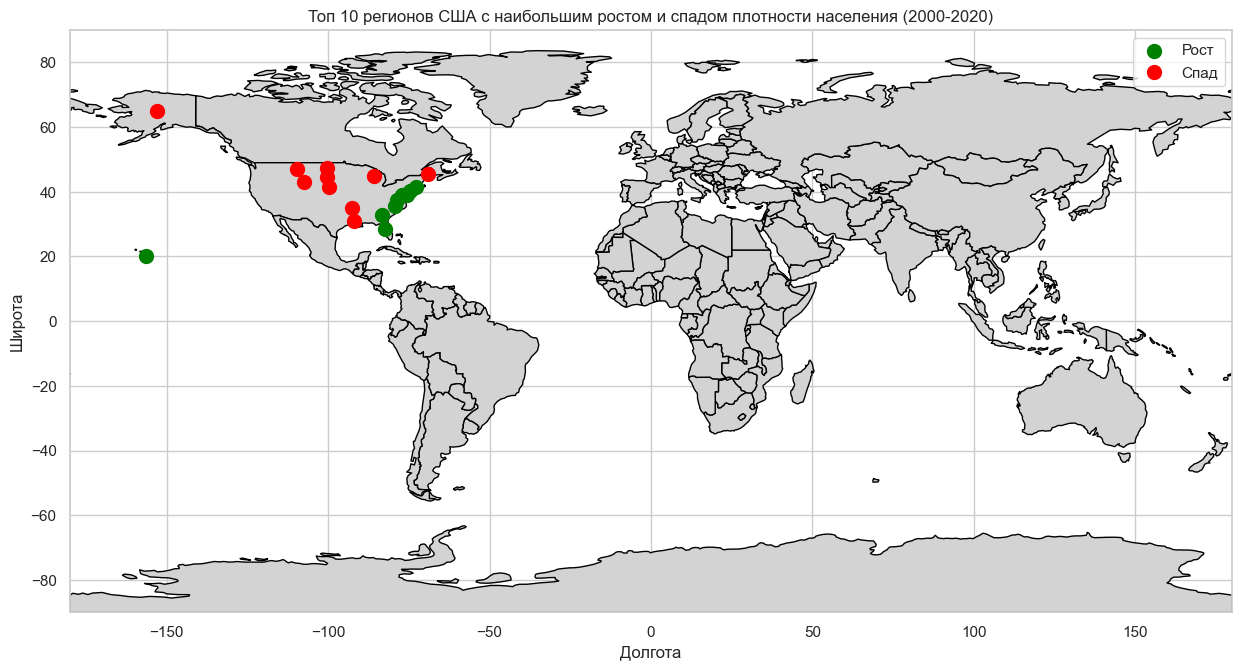

In [66]:
# Путь к скачанному файлу
world = gpd.read_file('data/ne_110m_admin_0_countries.shp')

# Устанавливаем систему координат, если она отсутствует
if world.crs is None:
    world.set_crs(epsg=4326, inplace=True)

# Преобразуем regions_gdf в проекцию EPSG:3857 для вычисления центроидов
regions_gdf_metric = regions_gdf.to_crs(epsg=3857)
regions_gdf['centroid'] = regions_gdf_metric.geometry.centroid

# Преобразуем координаты центроидов обратно в EPSG:4326
regions_gdf['centroid'] = regions_gdf['centroid'].to_crs(epsg=4326)

# Визуализация топ-10 регионов с ростом и спадом на карте
visualize_top_regions(top_growth, top_decline, world, regions_gdf)
